# Comparing the performance of the isolation forest algorithm on datasets drawn from different distributions

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

In [39]:
# functions TODO: fix error probability 
def generate_datasets(normal_distribution, error_distribution, error_probability):
    
    # sample 90% from normal dataset
    gaus_dist = random.sample(list(normal_distribution), 900)
    normal_points = ["no" for e in gaus_dist]

    # sample 10% from error dataset 
    cauchy_dist = random.sample(list(error_distribution), 100)
    outliers = ["yes" for e in cauchy_dist]

    numbers = gaus_dist + cauchy_dist 
    labels = normal_points + outliers 

    # Create df with two columns (number, label)
    df = pd.DataFrame({'number': numbers, 'label_gt': labels})
    df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

    # shuffle rows
    df = df.sample(frac=1)

    return df


def train_IF(dataset):
    # Train IF
    model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
    model.fit(dataset[['number']])

    dataset['scores']=model.decision_function(dataset[['number']])
    dataset['anomaly']=model.predict(dataset[['number']])
    dataset["anomaly"] = np.where(dataset['anomaly']== -1, "yes", "no")

    outliers=dataset.loc[dataset['anomaly']=="yes"]
    outlier_index=list(outliers.index)

    return model, dataset

def anomaly_detection_visualisation(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    plt.plot(df['number'],df['scores'], '.')
    plt.title("datapoints and predicted anomaly score")
    plt.xlabel("datapoint (number)")
    plt.ylabel("anomaly score")
    outliers = df[df["anomaly"] == "yes"]
    non_outliers = df[df["anomaly"] == "no"]
    
    plt.figure()
    plt.title("outliers and non outliers")
    outliers_data = pd.DataFrame({'number': outliers["number"], 'scores': outliers["scores"]})
    sns.scatterplot(x="number", y="scores", data=outliers_data, palette='red', label='outliers');

    normal_data = pd.DataFrame({'number': non_outliers["number"], 'scores': non_outliers["scores"]})
    sns.scatterplot(x="number", y= "scores", data=normal_data, palette='green', label='non outliers');

    # plt.figure()
    # plt.title("outliers anomaly score")
    # data = pd.DataFrame({'number': non_outliers["number"], 'scores': non_outliers["scores"]})
    # sns.scatterplot(x="number", y="scores", data=data, palette='g')

def plot_histogram_of_datasets(normal_dataset, outliers_dataset):    
    fig, axis = plt.subplots(1,2,figsize=(12,8))

    sns.histplot(normal_dataset, ax=axis[0], shrink=0.8, stat='count').set(title=f"Non outliers: Data distribution for mean:{mu_centered} and std:{sigma_centered}")
    axis[0].axvline(normal_dataset.mean(), color='green', label='mean')
    axis[0].legend()

    sns.histplot(outliers_dataset, ax=axis[1], shrink=0.8, stat='count').set(title=f"outliers: Data distribution for mean:{mu_shifted} and std:{sigma_shifted}")
    axis[1].axvline(outliers_dataset.mean(), color='green', label='mean')
    axis[1].legend()

    plt.show()
    print(f'μ_centered ={normal_dataset.mean()}')
    print(f'σ_centered ={normal_dataset.std()}')
    print(f'μ_shifted ={outliers_dataset.mean()}')
    print(f'σ_shifted ={outliers_dataset.std()}')

#plot_histogram_of_datasets(s_normal_centered,s_normal_shifted)
#anomaly_detection_visualisation(df)

# Sampling from two different gaussian distributions

In [4]:
mu_centered, sigma_centered = 0, 0.1
s_normal_centered = np.random.normal(mu_centered, sigma_centered, 10000)

mu_shifted, sigma_shifted = 10, 0.2
s_normal_shifted = np.random.normal(mu_shifted, sigma_shifted, 10000)

# Data sets generation one Gaussian

In [6]:
# sample 90% from centered dataset
centered_dist = random.sample(list(s_normal_centered), 1000)
normal_points = ["no" for e in centered_dist]

# sample 10% from shifted dataset 
# shifted_dist = random.sample(list(s_normal_shifted), 100)
# outliers = ["yes" for e in shifted_dist]

numbers = centered_dist #+ shifted_dist 
labels = normal_points #+ outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

In [7]:
df.head()

,number,label_gt,numeric_label_gt
0,0.019702,no,1
1,0.123289,no,1
2,0.044568,no,1
3,-0.048100,no,1
4,-0.069291,no,1


In [8]:
df.tail()

,number,label_gt,numeric_label_gt
995,0.036859,no,1
996,-0.177684,no,1
997,-0.085580,no,1
998,-0.065274,no,1
999,0.165228,no,1


In [9]:
df.describe()

,number,numeric_label_gt
count,1000.000000,1000.0
mean,-0.000044,1.0
std,0.100191,0.0
min,-0.330839,1.0
25%,-0.068419,1.0
50%,-0.001515,1.0
75%,0.065857,1.0
max,0.298543,1.0


# Isolation Forest

In [10]:
# Train IF, K-means, RF, SVDD? 
from sklearn.ensemble import IsolationForest

# The frac keyword argument specifies the fraction of rows to return in the random sample, 
# so frac=1 means to return all rows in random order
df = df.sample(frac=1)


# max_samples: The number of samples to draw from X to train each base estimator.
# max_features: The number of features to draw from X to train each base estimator.
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.01,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly_numerical']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly_numerical']== -1, "yes", "no")
print(df['anomaly'].value_counts())
(df["anomaly"] == df["label_gt"]).value_counts()

no     990
yes     10
Name: anomaly, dtype: int64


True     990
False     10
dtype: int64

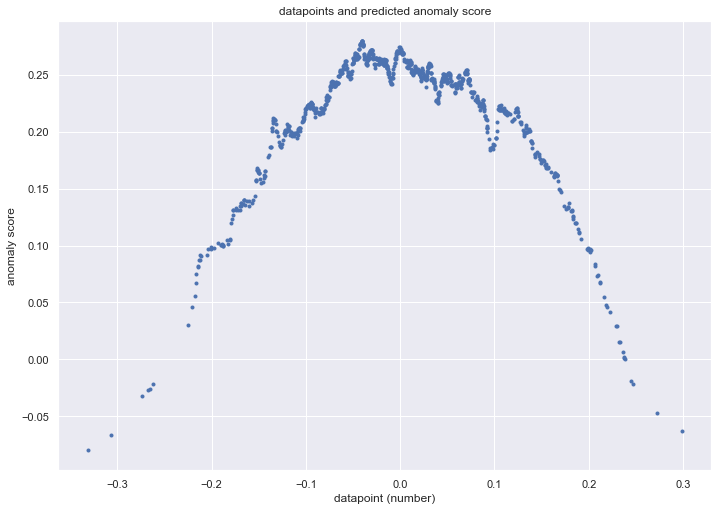

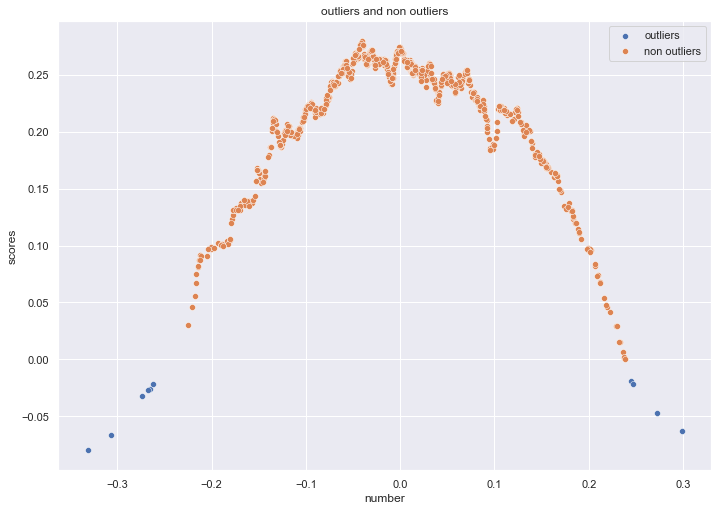

In [11]:
# Visualize results
anomaly_detection_visualisation(df)

## Using Grid Search to find the best set of parameters for IF

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

my_scoring_func = make_scorer(f1_score)
parameters = {'n_estimators':[10,30,50,80,100], 
            'max_features':[0.1,0.2,0.3,0.4,1.0], 
            'contamination' : [0.1,0.2,0.3]
            }
isolation_forest =  IsolationForest(max_samples='auto')
search = GridSearchCV(isolation_forest, parameters,  scoring=my_scoring_func)
search.fit(df[['number']], df[['numeric_label_gt']])

GridSearchCV(estimator=IsolationForest(),
             param_grid={'contamination': [0.1, 0.2, 0.3],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 1.0],
                         'n_estimators': [10, 30, 50, 80, 100]},
             scoring=make_scorer(f1_score))

In [13]:
result_search_df = pd.DataFrame(search.cv_results_)
best_estimators = result_search_df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()
print(f"Best estimator parameters: {best_estimators.iloc[0]['params']}")

Best estimator parameters: {'contamination': 0.1, 'max_features': 0.2, 'n_estimators': 80}


In [14]:
optimal_forest = search.best_estimator_
pred = optimal_forest.predict(df[['number']])

h = (pred == df['numeric_label_gt']).value_counts()
h

True     900
False    100
Name: numeric_label_gt, dtype: int64

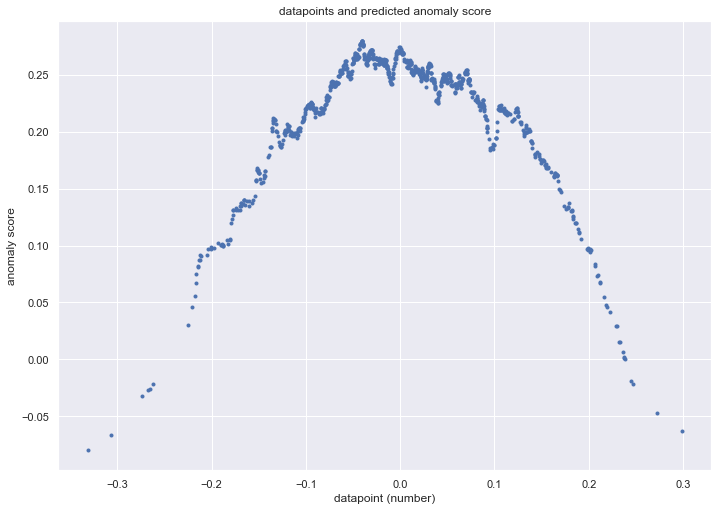

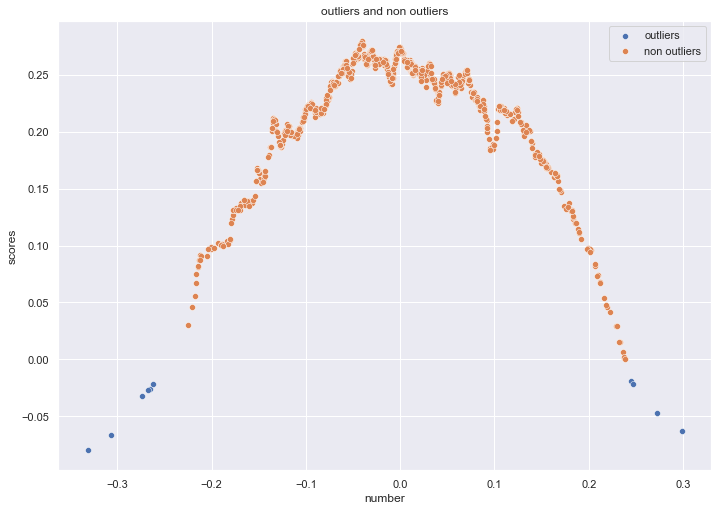

In [15]:
# Visualize results
#model, df = train_IF(df)
anomaly_detection_visualisation(df)

# Sampling from two different distributions: Gaussian and Poisson

In [16]:
mu_gau, sigma_gau = 0, 0.1
s_normal = np.random.normal(mu_gau, sigma_gau, 1000)

s_poisson = np.random.poisson(5, 1000)

μ_centered =-0.003626459865898288
σ_centered =0.09711875746345038
μ_shifted =4.969
σ_shifted =2.2521187801712412


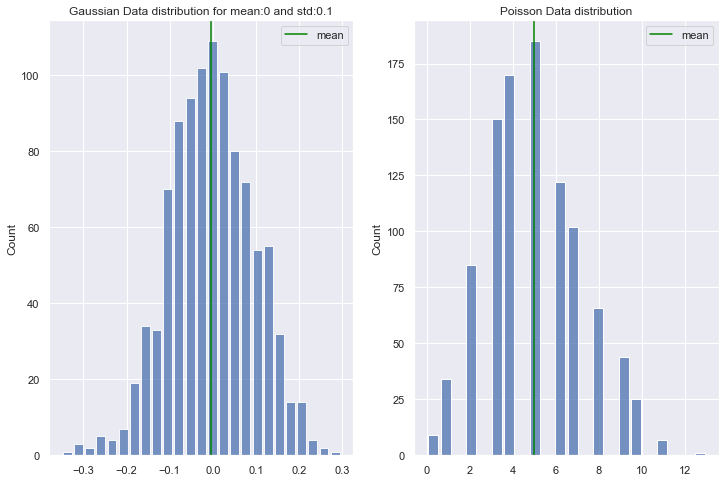

In [17]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal, ax=axis[0], shrink=0.8, stat='count').set(title=f"Gaussian Data distribution for mean:{mu_gau} and std:{sigma_gau}")
axis[0].axvline(s_normal.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_poisson, ax=axis[1], shrink=0.8, stat='count').set(title=f"Poisson Data distribution")
axis[1].axvline(s_poisson.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal.mean()}')
print(f'σ_centered ={s_normal.std()}')
print(f'μ_shifted ={s_poisson.mean()}')
print(f'σ_shifted ={s_poisson.std()}')

In [18]:
# sample 90% from centered dataset
gaus_dist = random.sample(list(s_normal), 900)
normal_points = ["no" for e in gaus_dist]

# sample 1% from shifted dataset 
poisson_dist = random.sample(list(s_poisson), 100)
outliers = ["yes" for e in poisson_dist]

numbers = gaus_dist + poisson_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

df = df.sample(frac=1)

In [19]:
# Train IF
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")
print(df['anomaly'].value_counts())
print(f"predictions: \n {(df['anomaly'] == df['label_gt']).value_counts()}")

no     918
yes     82
Name: anomaly, dtype: int64
predictions: 
 True     976
False     24
dtype: int64


# Sampling from two different distributions: Gaussian and standard_cauchy

In [20]:
mu_gau, sigma_gau = 0, 0.1

s_normal = np.random.normal(mu_gau, sigma_gau, 1000)

s_std_cauchy = np.random.standard_cauchy(1000)
# truncate distribution so it plots well
s_std_cauchy = s_std_cauchy[(s_std_cauchy>-25) & (s_std_cauchy<25)]
len(s_std_cauchy)

977

μ_centered =0.002808211676437015
σ_centered =0.09854376352308683
μ_shifted =0.1508582998250148
σ_shifted =3.7464150838715984


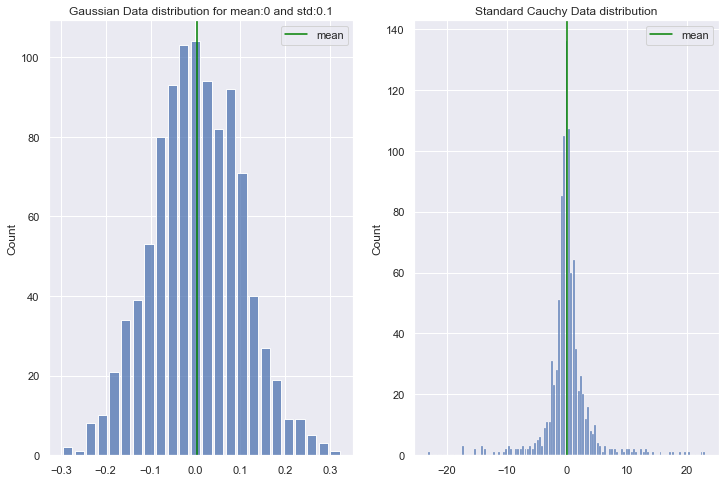

In [21]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal, ax=axis[0], shrink=0.8, stat='count').set(title=f"Gaussian Data distribution for mean:{mu_gau} and std:{sigma_gau}")
axis[0].axvline(s_normal.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_std_cauchy, ax=axis[1], shrink=0.8, stat='count').set(title=f"Standard Cauchy Data distribution")
axis[1].axvline(s_std_cauchy.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal.mean()}')
print(f'σ_centered ={s_normal.std()}')
print(f'μ_shifted ={s_std_cauchy.mean()}')
print(f'σ_shifted ={s_std_cauchy.std()}')

In [22]:
# sample 90% from centered dataset
gaus_dist = random.sample(list(s_normal), 900)
normal_points = ["no" for e in gaus_dist]

# sample 10% from shifted dataset 
cauchy_dist = random.sample(list(s_std_cauchy), 100)
outliers = ["yes" for e in cauchy_dist]

numbers = gaus_dist + cauchy_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

df = df.sample(frac=1)

In [23]:
# Train IF
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")

#print(f"Ground Truth: \n {df['anomaly'].value_counts()}")
#print(f"\n predictions: \n {(df['anomaly'] == df['label_gt']).value_counts()}")

outliers=df.loc[df['anomaly']=="yes"]
outlier_index=list(outliers.index)
#print(outlier_index)

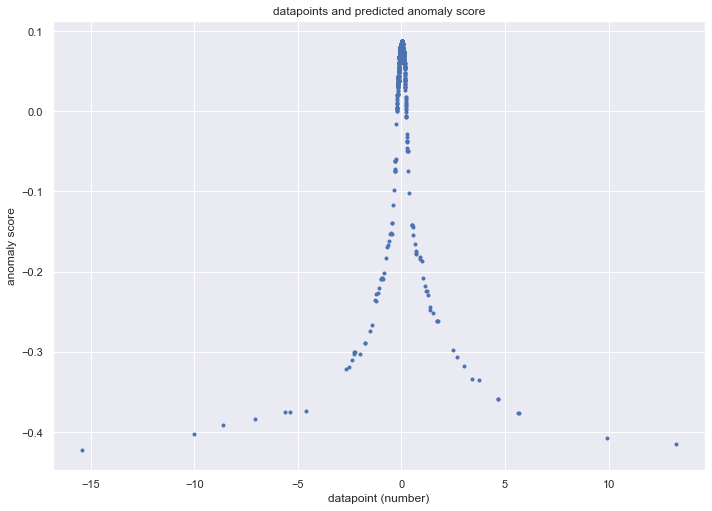

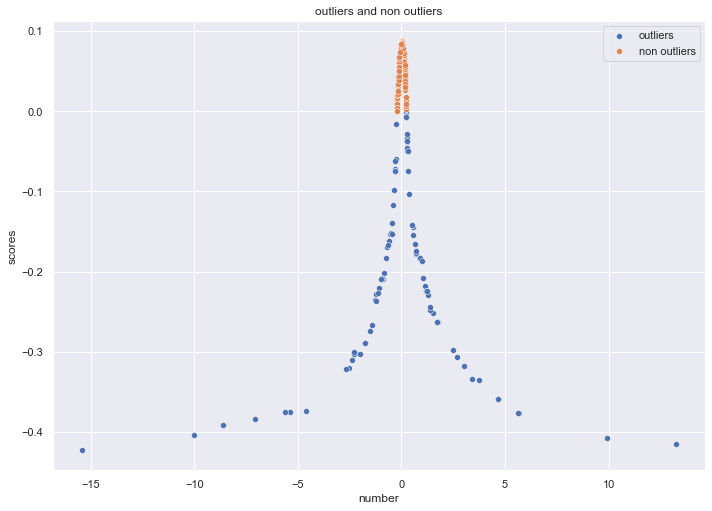

In [24]:
anomaly_detection_visualisation(df)

# Visualization

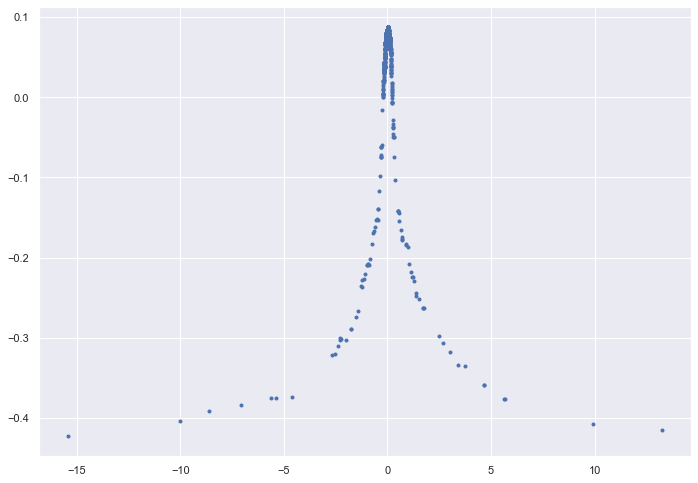

In [25]:
plt.plot(df['number'],df['scores'], '.')

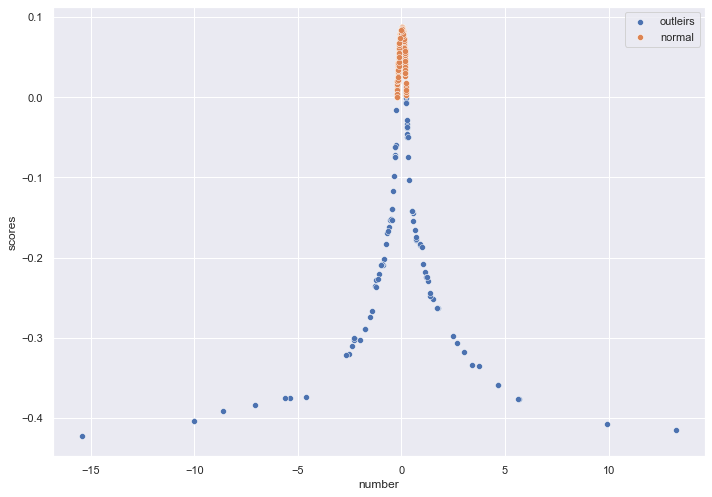

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
outliers = df[df["anomaly"] == "yes"]
non_outliers = df[df["anomaly"] == "no"]

sns.scatterplot(x=outliers["number"], y= outliers["scores"], palette='r', label="outleirs");
sns.scatterplot(x=non_outliers["number"], y= non_outliers["scores"], palette='g', label="normal");

<AxesSubplot:xlabel='number', ylabel='scores'>

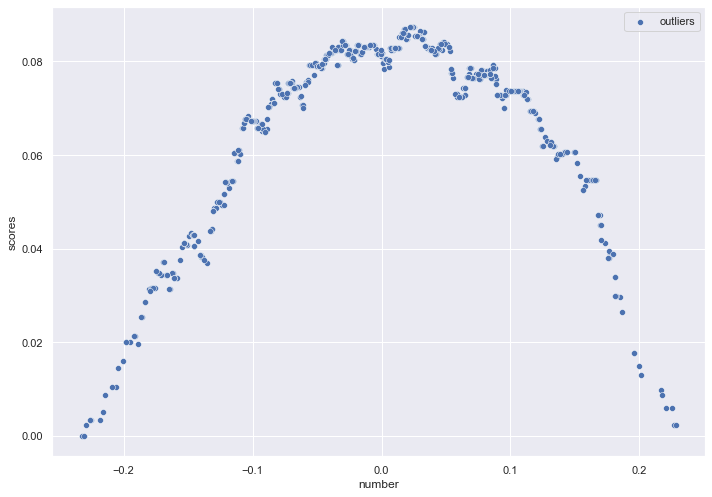

In [36]:
sns.scatterplot(x=non_outliers["number"], y=non_outliers["scores"], palette='g', label="outliers")

# Data set generation: Sampling from Gaussian and Cauchy distributions using functions

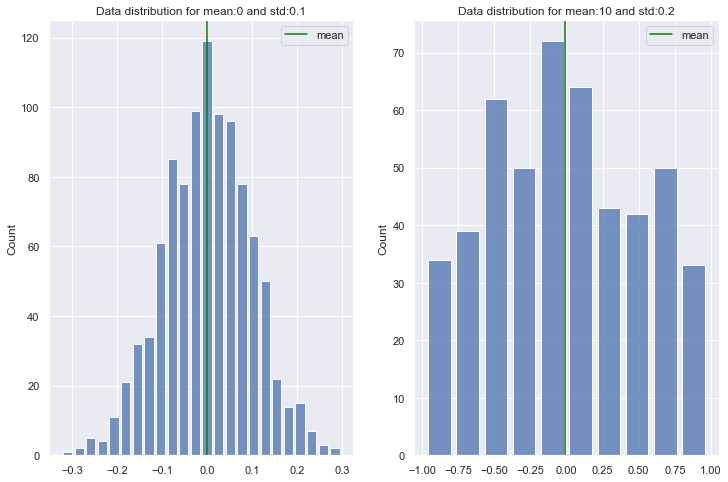

μ_centered =0.000664815115665561
σ_centered =0.09691409142544685
μ_shifted =-0.012167185205681115
σ_shifted =0.5115963675164996


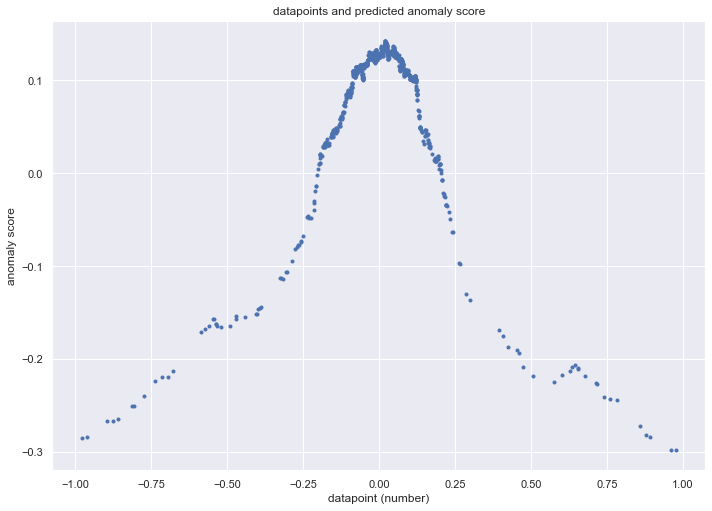

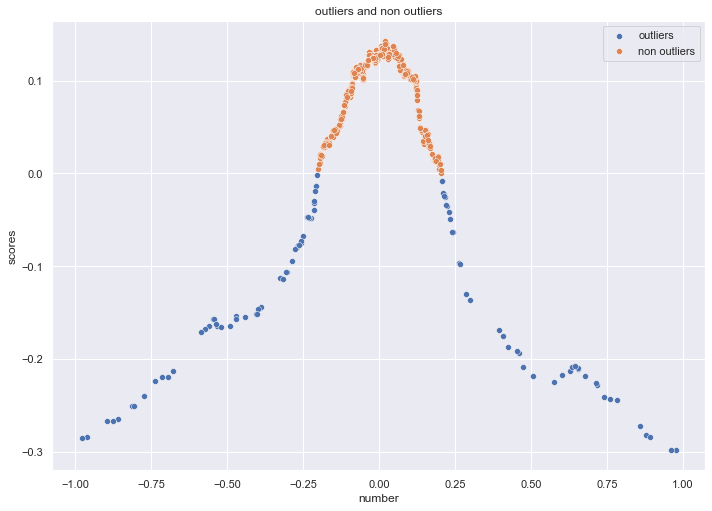

In [28]:
# generate distributions 
mu_gau, sigma_gau = 0, 0.1
normal_distribution = np.random.normal(mu_gau, sigma_gau, 1000)
error_distribution = np.random.standard_cauchy(1000)
# truncate distribution so it plots well
error_distribution = error_distribution[(error_distribution>-1) & (error_distribution<1)]

plot_histogram_of_datasets(normal_distribution,error_distribution)

# generate dataset 
ds1 = generate_datasets(normal_distribution, error_distribution, error_probability=0.1)

# Train IF 
model, ds1_post_det = train_IF(ds1)

# Visualization
anomaly_detection_visualisation(ds1_post_det)

# # Data set generation: Sampling from two Gaussian distributions

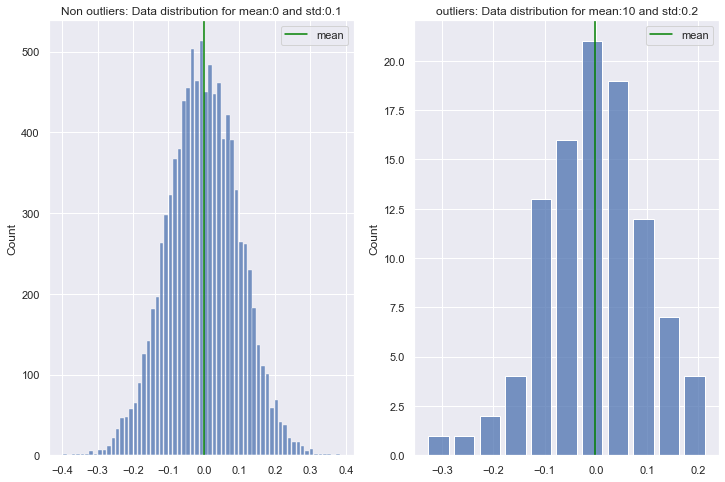

μ_centered =-0.0012451933840368823
σ_centered =0.09972967581368647
μ_shifted =-0.002050482615029955
σ_shifted =0.10146467394375862


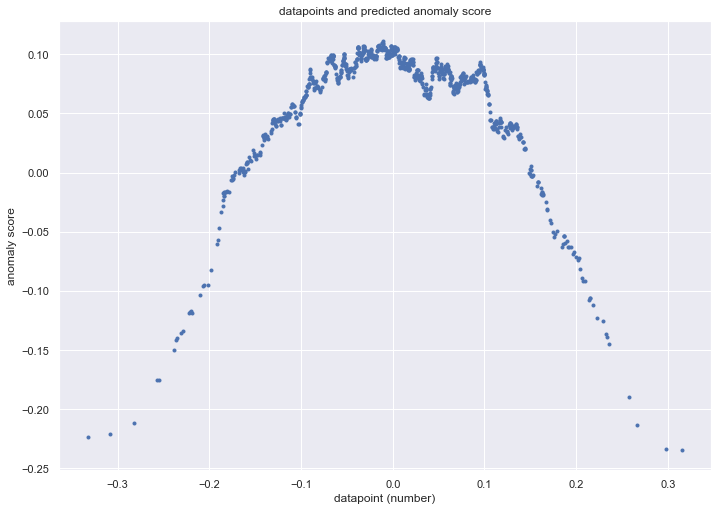

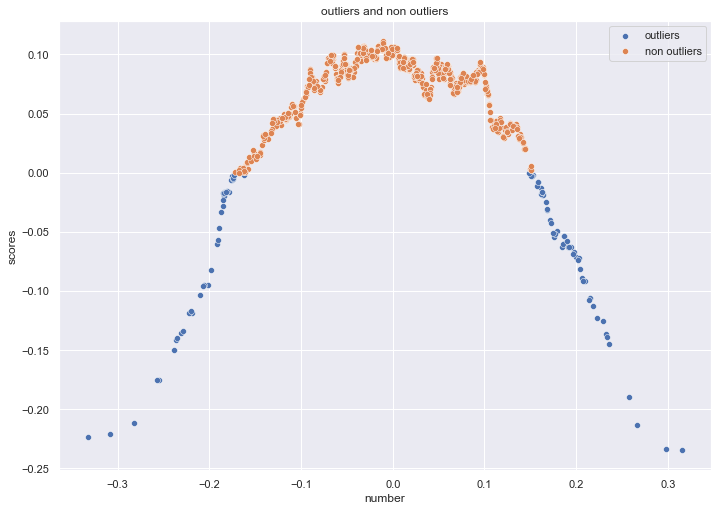

In [40]:
# generate distributions 
mu_gau, sigma_gau = 0, 0.1
normal_distribution = np.random.normal(mu_gau, sigma_gau, 10000)
error_distribution = np.random.normal(mu_gau, sigma_gau, 100)

# truncate distribution so it plots well
# error_distribution = error_distribution[(error_distribution>-1) & (error_distribution<1)]

plot_histogram_of_datasets(normal_distribution,error_distribution)

# generate dataset 
ds1 = generate_datasets(normal_distribution, error_distribution, error_probability=0.1)

# Train IF 
model, ds1_post_det = train_IF(ds1)

# Visualization
anomaly_detection_visualisation(ds1_post_det)